In [9]:
include("../../startup.jl")
using DifferentialEquations, NumericallyIntegrateArrays, Distributions, StatsBase
#using RoostFinder

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file C:\Users\lucy_\.julia\compiled\v1.1\Distributions\xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184


In [10]:
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 
msd_rt = meansd;
sem_rt = semsd;
std_rt = stdsd;

In [27]:
function r2_test(ydata,ymodel)
    """
    Calculate the r² value for ydata and ymodel
    Each point ydata and ymodel must be at the same x point
    """
    sstot = 0
    ssres = 0
    for (yd,ym) in zip(ydata,ymodel)
        sstot += (yd - mean(ydata))^2
        ssres += (yd - ym)^2
    end
    return 1- ssres/sstot
end

function diffusions!(du,u,p,t)
    d,n = p
    du[1] = d*(u[2]-u[1])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1])
    end
    du[n] = d*(u[n-1]-u[n])
end

function ABC(f::Function, d::Function, prior, N::Int, Y::Array)
    """
    f = a function to generate X values that takes as input a tuple of parameters θ.
    d = function giving a distance measure
    prior = a named tuple of parameter distributions
    N = number of samples
    Y = summary statistics of the data
    The function ABC generates N sets of parameters from priors, calculates
    summary statistics X from each set of parameters with f and calculates
    distance measure from the function given by d.
    Then, sorts parameters θ by distance and returns θ and distance
    """
    distance=[]
    θ = []
    for p in prior
        append!(θ, [rand(p, N)])
    end
    for i in 1:N
        θs = [θ[v][i] for v in 1:length(θ)]
        X = f(θs)
        append!(distance, d(X,Y))
    end
    for (i,p) in enumerate(θ)
        θ[i] = p[sortperm(distance)]
    end
    sort!(distance)
    return θ, distance
end


function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink(θ, d, dt,u0, t, tD)
  #  u = [u0]
    boxsize = zeros(Int, size(t))
    boxsize[t_rt .<= θ[2]] .= L/dx
    boxsize[t_rt .> θ[2]] .= Int.(ceil.(shrink_rate(t_rt[t_rt .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>L/dx] .= L/dx
    boxsize[end] = 1
    tspan = (0.0, dt)
    msd = [trapz(u0.*x[1:size(u0)[1]].^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(diffusions!,u0,tspan,(d,ns))
            u0 = solve(prob).u[end]
        end
        append!(msd,trapz(u0.*x[1:length(u0)].^2,dx))
  #      append!(u,[u0])
        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
            end
        end 
        
    end
    return msd
end

function fs(θ, dt, u0, t, msd_rt)
    """
    This is the function to be minimised.
    """
    X = domain_shrink(θ, dt,u0, t)
    a = (X.-msd_rt)^2
    return a[1]
end

function GMM(prior, dt, u0, t, msd_rt)
    result = bboptimize(θ->fs(θ, dt, u0, t, msd_rt);
    SearchRange = prior,
    TraceMode=:silent
    )
return best_candidate(result)
end


GMM (generic function with 1 method)

  1.807298 seconds (3.35 M allocations: 202.187 MiB, 4.73% gc time)
-5.6119871642847245

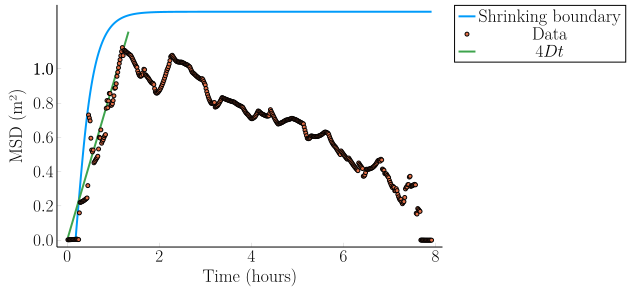

In [24]:
L = 2000
N = 50
dx = div(L,N)
D = 63.4#5062.87
d = D/dx^2
u = zeros(N)
T = 3600
dt = 400.0
tD = 600.0

#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx


prior = [Uniform(2.5e6,4e6), Uniform(0.0,7.2e3)]
@time msds = domain_shrink([L^2,1e3],d,dt,u0,t_rt,tD)
    

print(r2_test(msds,msd_rt))
plot(t_rt./3600, msds./1e6, label="Shrinking boundary")
scatter!(t_rt./3600,msd_rt./1e6,label="Data")
plot!(t_rt[1:80]./3600,4*D*(t_rt[1:80])./1e6, label=L"4Dt")
plot!(xlabel="Time (hours)",ylabel="MSD (m²)")
#savefig("shrinking_bound.png")

In [29]:
prior = [Uniform(1500,2500), Uniform(0.0,2000.0)]
@time θ, r2 = ABC(θ -> domain_shrink(θ,d,dt,u0,t_rt,tD), r2_test, prior, 10000, msd_rt)

1116.206005 seconds (3.37 G allocations: 602.420 GiB, 10.12% gc time)


(Any[[2492.85, 2499.4, 2494.49, 2489.53, 2494.98, 2486.97, 2486.39, 2492.54, 2498.23, 2494.49  …  1756.89, 1754.99, 1755.22, 1751.06, 1753.84, 1754.49, 1753.52, 1756.18, 1752.69, 1753.25], [1968.39, 1797.06, 1930.74, 1947.01, 1793.16, 1976.71, 1984.03, 1831.86, 1682.71, 1781.22  …  856.235, 748.325, 1054.11, 953.771, 917.861, 913.696, 778.0, 975.756, 810.81, 1075.71]], Any[-0.172286, -0.171781, -0.171781, -0.169605, -0.167642, -0.166588, -0.166143, -0.166089, -0.165993, -0.165476  …  0.862738, 0.862738, 0.862786, 0.862795, 0.862817, 0.862822, 0.862825, 0.862866, 0.862874, 0.862994])

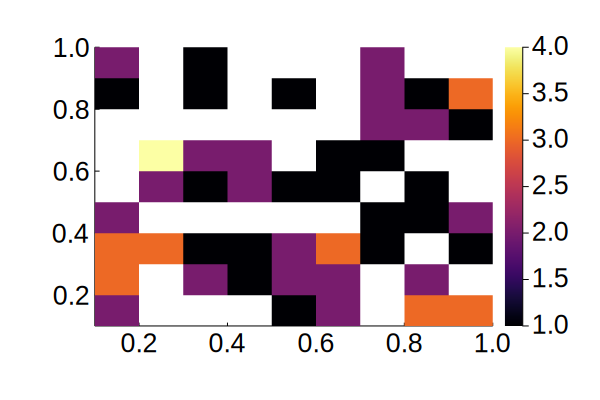

In [35]:
histogram2d(rand(100),rand(100), bins=(0.1:0.1:1, 0.1:0.1:1))#,[0.1:0.1:1]])

In [39]:
gr()
p1 = plot(xlabel=L"R_0", ylabel=L"t_S", 
    colorbar_title="Frequency",title="Prior",
    xlims=(1500,2500))
histogram2d!(θ[1],θ[2], label="", bins = (1500:100:2500,0:200:2000))

p2 = plot(xlabel=string("Time (hours)"), ylabel="MSD", 
    xlims=(1500,2500),ylims=(0,2000))
histogram2d!(θ[1][9900:10000],θ[2][9900:10000],  bins = (1500:100:2500,0:200:2000),
    label="",xlabel=L"R_0", 
    ylabel=L"t_S", colorbar_title="Frequency", title="Posterior")#

plot(p1,p2,size=(1500,500))
savefig("../figs/prior_posterior.png")

In [86]:
R_0 = θ[1][end]#sqrt(mean(θ[1][end-100:end]))
t_s = θ[2][end]

1755.641924245614

In [12]:
R_0 = 1755.6
t_s = 901
msds, u = domain_shrink([R_0,t_s],d,dt,u0,t_rt, tD)

([800.0, 800.0, 800.0, 800.0, 800.0, 800.0, 800.0, 800.0, 800.0, 800.0  …  53570.8, 44025.0, 43473.4, 34638.7, 34330.3, 26420.1, 19369.9, 19333.8, 13444.0, 4799.78], Array{Float64,1}[[0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.

In [16]:
@save "shrink_bound.jld2" t_rt msds u dx L

In [108]:
plot(xlabel=string("Time from sunset (hours)"), ylabel="MSD (km²)", 
    markersize=8, color=:red, label="Mean squared distance",
    size=(800,500), grid=false,
    ylims=(0,1.6),
    tickfontsize=15, guidefontsize=15, legendfontsize=12, margin=10mm)
scatter!(t_rt./3600., meansd./10^6, label="Mean",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red)
scatter!(t_rt./3600., meansd./10^6, label="Standard error",
    ribbon=semsd.-semsd, fill=:orange, marker = :square, markerstrokecolor=:white,
    markersize=0, color=:orange)
scatter!(t_rt./3600., meansd./10^6, label="",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red)
plot!(t_rt./3600, msds./1e6, label="Shrinking boundary",color=:blue)
savefig("../figs/fit_msd.png")

0.9297981715758608

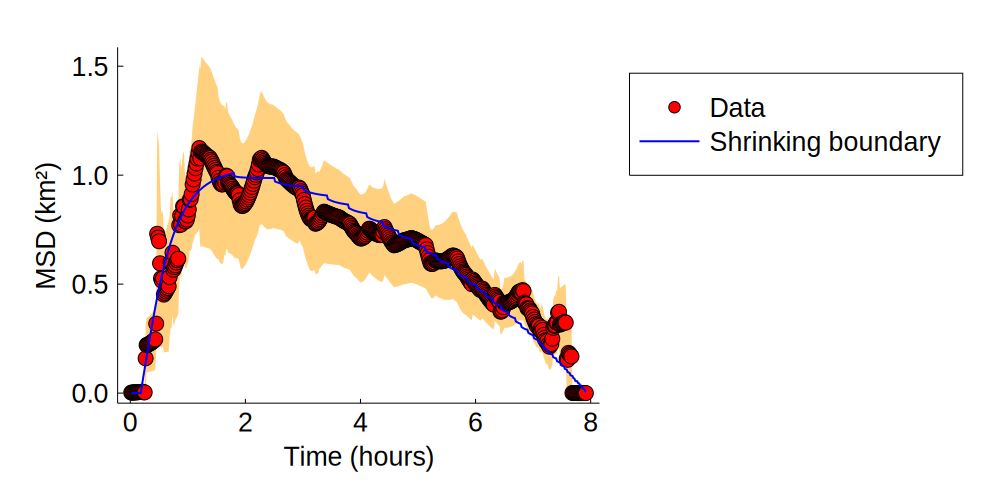

In [104]:
gr()
N = 100
dt = 200.0
msds, u = domain_shrink([R_0,t_s],d,dt,u0,t_rt, tD)
plot(xlabel=string("Time (hours)"), ylabel="MSD (km²)")
print(r2_test(msds,msd_rt))
scatter!(t_rt./3600,msd_rt./1e6,label="Data",
    markersize=8, colour=:red,
    ribbon=sem_rt./10^6, fill=:orange)
plot!(t_rt./3600, msds./1e6, label="Shrinking boundary",color=:blue,legend=:outertopright)
plot!(size=(1000,500))
#savefig("../figs/shrinking_bound.png")